# Increased Confidence in Metabolite Identity from CE-MS through Migration Time Prediction by Machine Learning with Scikit-Learn
---

> 07-December-2018


> Michael Loewen (qq123456) & Bill Zizek (qq268547)


> SCS 3253
--- 
## Introduction
**Capillary Electrophoresis (CE) - Mass Spectrometry (MS)** is a multi-dimensional analytical separation instrument used for analysis of biological samples among others. Upon injection, a current is applied and compounds within samples are separated as they migrate through the capillary by their respective electrophoretic mobility differences before reaching a time-of-flight (TOF) mass detector. In spite of CE-MS being a highly accurate and robust detection method, ambient and human variables can cause the same compound to migrate at different times despite otherwise identical conditions. This variability has no impact on the detection and quantification of compounds. However, dependable known migration times through a predictive model empowers replacement of expensive chemical standards through higher confidence of compound identification by additional evidence to accurate mass and isotopic pattern information and thus increases the value of datasets containing unknowns. With multiple experimental runs, there may be multiple instances of a compound and recorded migration times. This dynamic experimental data is annotated with relevant physicochemical properties and miscellaneous metadata to provide context to produced machine learning results. For respective compounds, chemical databases can be used to extract properties to perform calculations for relevant features such as effective mobility, molecular volume, and absolute compound mobility. Following training and profiling of model performance, further annotation to chemical compound classes can give context to results stemming from the model.

## Goal

This experiment aims to explore:

1. Using four independent variables (1. m/z, 2. pKa, 3. logP, and 4. Van der Waals molecular volume) can we predict a drug's relative migration time (FPhe_RMT)?
2. Can a machine learning algorithm improve accuracy in predicting FPhe_RMT over a standard linear regression approach?
3. Can we use machine learning to classify general drug classes using the aforementioned independent variables in question #1?

## Variables

`Experiment #` is a unique identifier corresponding to instrumental data acquisition. Each "experiment" takes 30-45 minutes and contains data for many different compounds. The experimental data captured per `Experiment #` is a measurd `m/z` value, `MT_sec`, and many other data points not relevant to the scope of this study.

`m/z` is a compound's mass-to-charge ratio (observed mass divided by charge number). In this study, each `Compound` has it's own respective `m/z` value but in practice many compounds can have the same `m/z` value.

`Compound` is a name identifier for drug compounds in this study. Compound identity has been confirmed already by `m/z`, relative migration time, and comigrating internal standards for unambiguous ID.

`MT_sec` is the migration time of a compound's peaks measured in seconds.

`FPhe_RMT` is a ratiometric calculation per `Experiment #`. A respective compounds `MT_sec` is divided by the `MT_sec` of F-Phe within the corresponding `Experiment #`.

`Drug Class` is a family classification that relates to the respective `Compound`.

`Monoisotopic Mass` is the sum of the masses of the atoms in a molecule using the unbound, ground-state, rest mass of the principal (most abundant) isotope.

`pKa`, `logP`, and `Van der Waals volume` are physicochemical properties pertinent to the theory of Capillary Electrophoresis that contribute to differences in compound migration time.

---

## Data Import and Exploratory Inspection

In [1]:
import pandas as pd
data = pd.read_csv("./data/MT_data.csv")
data.head()

,Experiment #,m/z,Compound,MT_sec,FPhe_RMT,Drug Class,pKa,logP,Van der Waals volume
0,1,141.1435,Amphetamine-d5,944.70,0.796207,Internal Standard,10.01,1.80,144.86
1,1,172.1332,Gabapentin,1018.32,0.858255,Other,9.91,-1.27,176.16
2,1,177.1022,Cotinine,967.56,0.815474,Other,4.79,0.21,165.31
3,1,178.1226,Mephedrone,1000.38,0.843135,Amphetamine,8.05,2.12,181.62
4,1,184.0768,F-Phe,1186.50,1.000000,Internal Standard,9.45,-1.04,160.46


![CompoundRMT Boxplot](./figures/compoundRMT_boxplot_clean.png)

In [2]:
compound_freq = pd.read_csv("./figures/compound_freqtable.csv")
compound_freq.head()

,Compound,n
0,6-acetylmorphine,27
1,7-aminoclonazepam,27
2,7-aminoflunitrazepam,27
3,Amitriptyline,27
4,Amphetamine-d5,27


In [3]:
drugClass_freq = pd.read_csv("./figures/drugClass_freqtable.csv")
drugClass_freq

,Drug Class,n
0,Amphetamine,108
1,Anesthetic,148
2,Antidepressants,281
3,Internal Standard,54
4,Opioid,512
5,Other,122
6,Sedative,189
7,Stimulant,81


![drugClassRMT Boxplot](./figures/drugClassRMT_box.png)

In [4]:
X = data[['m/z', 'pKa','logP', 'Van der Waals volume']] 
X.head()

,m/z,pKa,logP,Van der Waals volume
0,141.1435,10.01,1.80,144.86
1,172.1332,9.91,-1.27,176.16
2,177.1022,4.79,0.21,165.31
3,178.1226,8.05,2.12,181.62
4,184.0768,9.45,-1.04,160.46


In [5]:
y = pd.DataFrame(data['FPhe_RMT'])
y.head()

,FPhe_RMT
0,0.796207
1,0.858255
2,0.815474
3,0.843135
4,1.000000


### Split Data into Training and Test Sets

In [6]:
from sklearn.model_selection import train_test_split

random_seed = 42 # consistent integer to set random_state

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1046, 4) (449, 4) (1046, 1) (449, 1)


### Preprocess the data for analysis

In [7]:
X_train.describe()

,m/z,pKa,logP,Van der Waals volume
count,1046.000000,1046.000000,1046.000000,1046.000000
mean,274.684023,8.377964,2.473222,258.078184
std,54.558588,2.324704,1.540359,48.572144
min,141.143500,2.650000,-1.350000,144.860000
25%,238.099300,7.960000,1.470000,233.740000
50%,282.087300,9.120000,2.530000,265.010000
75%,308.175700,9.745000,3.805000,285.750000
max,399.227800,13.780000,5.010000,376.570000


In [8]:
from sklearn.preprocessing import StandardScaler

# remove the mean and scale to unit variance
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

pd.DataFrame(data = X_train_standardized, columns = X_train.columns).describe()

,m/z,pKa,logP,Van der Waals volume
count,1.046000e+03,1.046000e+03,1.046000e+03,1.046000e+03
mean,-1.062248e-15,7.217511e-18,4.755066e-17,-1.077804e-15
std,1.000478e+00,1.000478e+00,1.000478e+00,1.000478e+00
min,-2.448824e+00,-2.465132e+00,-2.483220e+00,-2.332043e+00
25%,-6.708792e-01,-1.798782e-01,-6.516023e-01,-5.013126e-01
50%,1.357590e-01,3.193487e-01,3.687799e-02,1.427800e-01
75%,6.141599e-01,5.883287e-01,8.650029e-01,5.699780e-01
max,2.283845e+00,2.324863e+00,1.647662e+00,2.440668e+00


### Evaluate Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train_standardized, y_train)
print(reg.coef_, 
      reg.intercept_)

[[ 0.01396473 -0.00749949 -0.01360099  0.02622007]] [0.91455164]


In [10]:
reg.score(X_train_standardized, y_train) #R^2 value

0.5279496969092903

Simple multi-variate linear regression provided a 52.8% accuracy on training set. The accuracy without the pKa variable was 51.2%.

In [11]:
reg.score(X_test_standardized, y_test)

0.6134844763152294

Simple multi-variate linear regression provided a 61.3% accuracy on test set. The accuracy without the pKa variable was 59.6%.

## Proposed Machine Learning Models

### Regression to forecast `FPhe_RMT`
* SGDRegressor
* RandomForest
* KNeighborsRegressor

In [12]:
# Testing SGDRegressor
from sklearn import linear_model
import numpy as np

sgdreg = linear_model.SGDRegressor(max_iter=5000)
sgdreg.fit(X_train_standardized, y_train.values.ravel())

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=5000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [13]:
sgdreg.score(X_train_standardized, y_train)

0.5279491615381695

SGDRegressor provided 52.8% accuracy on the training set which is directly in line with linear regression. The accuracy without the pKa variable was 51.2%. 

In [14]:
sgdreg.score(X_test_standardized, y_test)

0.613380235283509

SGDRegressor provided 61.4% accuracy on the test set which is directly in line with linear regression. The accuracy without the pKa variable was 59.5%. 

In [15]:
sgdr=linear_model.SGDRegressor(max_iter=5000,random_state=random_seed)
sgdr

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=5000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [16]:
param_grid = {
    'alpha': 10.0 ** -np.arange(1, 7),
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}

In [17]:
from sklearn.model_selection import GridSearchCV
CV_sgdr = GridSearchCV(sgdr, param_grid)
CV_sgdr.fit(X_train_standardized, y_train.values.ravel())

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equival

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added 

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=5000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]), 'loss': ['squared_loss', 'huber', 'epsilon_insensitive'], 'penalty': ['l2', 'l1', 'elasticnet'], 'learning_rate': ['constant', 'optimal', 'invscaling']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [18]:
CV_sgdr.best_params_

{'alpha': 0.01,
 'learning_rate': 'optimal',
 'loss': 'squared_loss',
 'penalty': 'l2'}

{'alpha': 0.01,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'penalty': 'l2'}

In [19]:
sgdr1=linear_model.SGDRegressor(random_state=random_seed, max_iter=5000, alpha=0.01, learning_rate= 'optimal', loss='squared_loss', penalty='l2')

In [20]:
sgdr1.fit(X_train_standardized, y_train.values.ravel())

C:\Users\Seroclinix\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='squared_loss', max_iter=5000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [21]:
sgdr1.score(X_test_standardized, y_test)

0.612560965676781

In [22]:
#Testing RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

rfreg = RandomForestRegressor(max_depth=2, random_state=random_seed, n_estimators=100)
rfreg.fit(X_train_standardized, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [23]:
rfreg.score(X_train_standardized, y_train)

0.6094357981814132

RandomForestRegressor provided a 60.9% accuracy on training set, which is improved by ~8-9% compared to linear regression. The accuracy without the pKa variable is, surprisingly, identical.

In [24]:
rfreg.score(X_test_standardized, y_test)

0.6628584644339903

RandomForestRegressor provided a 66.3% accuracy on test set, which is improved by 5% compared to linear regression. The accuracy without the pKa variable is, surprisingly, identical.

Let's try to do some hyperparameter tuning...

In [25]:
rfc=RandomForestRegressor(random_state=random_seed)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' :['mse', 'mae']
}

In [26]:
rfc

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [27]:
from sklearn.model_selection import GridSearchCV

# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# CV_rfc.fit(X_train_standardized, y_train.values.ravel())

In [28]:
# CV_rfc.best_params_

{'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 200}

In [29]:
rfc1=RandomForestRegressor(random_state=random_seed, max_features='sqrt', n_estimators= 200, max_depth=8, criterion='mse')

In [30]:
rfc1.fit(X_train_standardized, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [31]:
rfc1.score(X_test_standardized, y_test)

0.986016034272195

With some hyperparameter tuning from a GridSearch, accuracy has been improved on the test set from 66.3% to 98.6%.

In [32]:
#Testing KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

KNreg = KNeighborsRegressor(n_neighbors=8)
KNreg.fit(X_train_standardized, y_train.values.ravel())

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=8, p=2,
          weights='uniform')

In [33]:
KNreg.score(X_train_standardized, y_train)

0.9896331630074446

KNeighborsRegressor provided a 99.0% accuracy on training set, which is drastically improved from 60-70% observed in other methods.

In [34]:
KNreg.score(X_test_standardized, y_test)

0.9873702169675063

KNeighborsRegressor provided a 99.0% accuracy on training set, which is drastically improved from 60-70% observed in other methods.

In [35]:
#import required packages
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_standardized, y_train)  #fit the model
    pred=model.predict(X_test_standardized) #make prediction on test set
    error = mean_squared_error(y_test,pred) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 5.341668168066908e-05
RMSE value for k=  2 is: 3.97867108546593e-05
RMSE value for k=  3 is: 3.8266438119251215e-05
RMSE value for k=  4 is: 3.593434343051163e-05
RMSE value for k=  5 is: 3.66216515288722e-05
RMSE value for k=  6 is: 3.333531500510709e-05
RMSE value for k=  7 is: 3.195659935797969e-05
RMSE value for k=  8 is: 3.1810073238650417e-05
RMSE value for k=  9 is: 2.9834787478085364e-05
RMSE value for k=  10 is: 2.9539149355064916e-05
RMSE value for k=  11 is: 2.9897395019683212e-05
RMSE value for k=  12 is: 3.0481717642613133e-05
RMSE value for k=  13 is: 2.9970101331486224e-05
RMSE value for k=  14 is: 3.0350980226372892e-05
RMSE value for k=  15 is: 3.0057809955923e-05
RMSE value for k=  16 is: 3.0474665333796554e-05
RMSE value for k=  17 is: 3.078529631588775e-05
RMSE value for k=  18 is: 3.2051746888125933e-05
RMSE value for k=  19 is: 3.569753244110506e-05
RMSE value for k=  20 is: 4.3771486330972304e-05


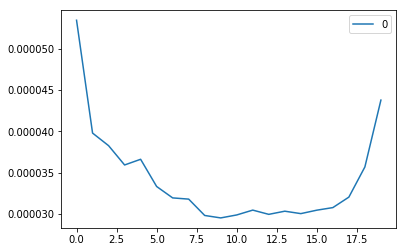

In [37]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [38]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(KNreg, X, y, cv=3)
scores 

array([0.98321376, 0.98954579, 0.97914785])

In [39]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.98 (+/- 0.01)


## Classification of Drug Class

* K-Neast Neighbors

In [40]:
X = data[['m/z', 'pKa','logP', 'Van der Waals volume']] 
y_class = pd.DataFrame(data['Drug Class'])
y_class.head()

,Drug Class
0,Internal Standard
1,Other
2,Other
3,Amphetamine
4,Internal Standard


In [41]:
# Create categories for y variable

from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
y_lb = lb.fit_transform(y_class)
lb.classes_

array(['Amphetamine', 'Anesthetic', 'Antidepressants',
       'Internal Standard', 'Opioid', 'Other', 'Sedative', 'Stimulant'],
      dtype='<U17')

In [42]:
y_class_lb = pd.DataFrame(data = y_lb, columns=lb.classes_)
y_class_lb.head()

,Amphetamine,Anesthetic,Antidepressants,Internal Standard,Opioid,Other,Sedative,Stimulant
0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class_lb, test_size=0.3, random_state=random_seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1046, 4) (449, 4) (1046, 8) (449, 8)


In [44]:
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

In [45]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train_standardized, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=8, p=2,
           weights='uniform')

In [46]:
knn.score(X_train_standardized, y_train)

1.0

In [47]:
knn.score(X_test_standardized, y_test)

1.0